In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
df = pd.read_csv('./resume_dataset.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


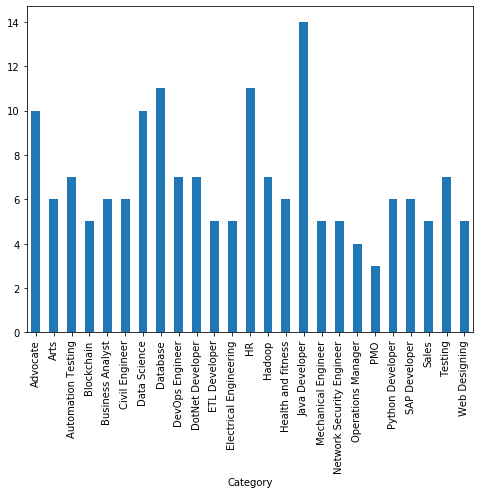

In [2]:
df['category_id'] = df['Category'].factorize()[0]
list(set(df['Category']))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Resume.count().plot.bar(ylim=0)
plt.show()

# Extract text

In [3]:
# Sources from https://stackoverflow.com/questions/11087795/whitespace-gone-from-pdf-extraction-and-strange-word-interpretation
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

class PdfConverter:

    def __init__(self, file_path):
        self.file_path = file_path

    def convert_pdf_to_txt(self):
        rsrcmgr = PDFResourceManager()
        retstr = StringIO()
        codec = 'utf-8'  # 'utf16','utf-8'
        laparams = LAParams()
        device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
        fp = open(self.file_path, 'rb')
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()
        for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
            interpreter.process_page(page)
        fp.close()
        device.close()
        str = retstr.getvalue()
        retstr.close()
        return str

    def save_convert_pdf_to_txt(self):
        content = self.convert_pdf_to_txt()
        txt_pdf = open('text_pdf.txt', 'wb')
        txt_pdf.write(content.encode('utf-8'))
        txt_pdf.close()
# if __name__ == '__main__':
pdfConverter = PdfConverter(file_path='Huy\'s+Resume.pdf')
my_resume = pdfConverter.convert_pdf_to_txt()

# Model Selection

In [4]:
y = df['category_id']

## Data analysis and Visualization

### Lemmatize Dataset

In [5]:
%%time
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

resumes = list(df['Resume'])
lemmatizer = WordNetLemmatizer()
resumes_lemmatized = [' '.join(lemmatizer.lemmatize(word)
    for word in nltk.word_tokenize(resume.lower().encode('ascii',errors='ignore').decode('ascii')))
    for resume in resumes]
print(resumes_lemmatized[0])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vuong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


skill * programming language : python ( panda , numpy , scipy , scikit-learn , matplotlib ) , sql , java , javascript/jquery . * machine learning : regression , svm , nave bayes , knn , random forest , decision tree , boosting technique , cluster analysis , word embedding , sentiment analysis , natural language processing , dimensionality reduction , topic modelling ( lda , nmf ) , pca & neural net . * database visualization : mysql , sqlserver , cassandra , hbase , elasticsearch d3.js , dc.js , plotly , kibana , matplotlib , ggplot , tableau . * others : regular expression , html , cs , angular 6 , logstash , kafka , python flask , git , docker , computer vision - open cv and understanding of deep learning.education detail data science assurance associatedata science assurance associate - ernst & young llpskill detail javascript- exprience - 24 month jquery- exprience - 24 month python- exprience - 24 monthscompany detail company - ernst & young llp description - fraud investigation a

### Generate Word Cloud

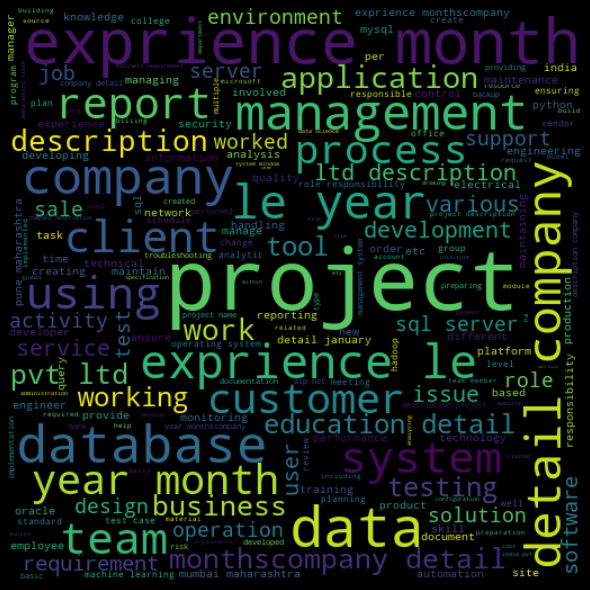

In [6]:
from wordcloud import WordCloud
%matplotlib inline

all_words = ''.join(list(resumes_lemmatized))
spam_wordcloud = WordCloud(width=512, height=512).generate(all_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_counts = count_vectorizer.fit_transform(resumes_lemmatized).toarray()
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)
X.shape
# print(X)

(169, 6942)

In [8]:
def vectorize_text(resume: str, count_vectorizer) -> np.ndarray:
    lemmatizer = WordNetLemmatizer()
    resume_lemmatized = [' '.join(lemmatizer.lemmatize(word)
        for word in nltk.word_tokenize(resume.lower()))]
#     count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
    X = count_vectorizer.transform(resume_lemmatized).toarray()
#     tfidf_transformer = TfidfTransformer()
    X = tfidf_transformer.fit_transform(X)
    return X

## Evaluate ensemble versus traditional methods

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV

In [10]:
def test_classification(X, y):
    # Check classification for various parameter settings.   
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    models = [
        RandomForestClassifier(),
        LinearSVC(),
        SVC(),
        MultinomialNB(),
        LogisticRegression(),
    ]

    for clf in models:
        scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1)
        bagging_clf = BaggingClassifier(base_estimator=clf, random_state=0, max_samples=1, max_features=4, bootstrap=True, bootstrap_features=False)
        bagging_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
        print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]'.format(clf.__class__.__name__, 
                   scores.mean(), scores.std()))
        print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n'.format(clf.__class__.__name__, 
                    bagging_scores.mean(), bagging_scores.std()))

import warnings
warnings.filterwarnings("ignore")
test_classification(X, y)

Mean of: 0.604, std: (+/-) 0.288 [RandomForestClassifier]
Mean of: 0.605, std: (+/-) 0.231 [Bagging RandomForestClassifier]

Mean of: 0.878, std: (+/-) 0.109 [LinearSVC]
Mean of: 0.847, std: (+/-) 0.114 [Bagging LinearSVC]

Mean of: 0.306, std: (+/-) 0.364 [SVC]
Mean of: 0.111, std: (+/-) 0.060 [Bagging SVC]

Mean of: 0.542, std: (+/-) 0.405 [MultinomialNB]
Mean of: 0.422, std: (+/-) 0.225 [Bagging MultinomialNB]

Mean of: 0.703, std: (+/-) 0.276 [LogisticRegression]
Mean of: 0.676, std: (+/-) 0.191 [Bagging LogisticRegression]



It seems that Bagging method does produces higher validation scores, but also induces higher variances that may needed to be consider

We will try 3 model: `LinearSVC`, `MultinomialNB`, `LogisticRegression` (Bagged and non bagged)

## Model Evaluation

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
def plot_confusion_heat_map(y_test, y_test_predicted) -> None:
    conf_mat = confusion_matrix(y_test, y_test_predicted)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=df['category_id'], yticklabels=df['category_id'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Evaluation on LinearSVC

In [12]:
params_grid = {'max_samples': [0.5, 1.0],
               'max_features': [1, 4, 10],
               'bootstrap': [True, False],
               'bootstrap_features': [True, False]}
bagging_linear_clf = BaggingClassifier(base_estimator=LinearSVC(loss='hinge', C=1, random_state=42))
bagging_linear_clf_cv = GridSearchCV(bagging_linear_clf, params_grid)
bagging_linear_clf_cv.fit(X, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=LinearSVC(C=1,
                                                                  class_weight=None,
                                                                  dual=True,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  loss='hinge',
                                                                  max_iter=1000,
                                                                  multi_class='ovr',
                                                                  penalty='l2',
                                                                  random_state=42,
                                                                  tol=0.0001,
                                                  

In [13]:
linear_clf = LinearSVC(loss='hinge', C=1, random_state=42)
linear_clf.fit(X_train, y_train)
y_test_predict = linear_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test_predict, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_test_predict, y_test))

Accuracy: 0.8837209302325582
Confusion Matrix:
 [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 

## Evaluation of LinearSVC on personal resume

In [14]:
file_path = 'duc-nguyen-resume.pdf'
linear_clf.fit(X, y)
pdfConverter = PdfConverter(file_path=file_path)
my_resume = pdfConverter.convert_pdf_to_txt()
y_predict = linear_clf.predict(vectorize_text(my_resume, count_vectorizer))
print('{} is categorized to be {}'.format(file_path, df.loc[df['category_id'] == y_predict[0]]['Category'].iloc[0]))
y_margins = linear_clf.decision_function(vectorize_text(my_resume, count_vectorizer))
y_prob = (y_margins - y_margins.min()) / (y_margins.max() - y_margins.min() + np.std(y_margins))
print(y_prob)

duc-nguyen-resume.pdf is categorized to be Java Developer
[[0.75222885 0.26633742 0.01642113 0.14400028 0.25440232 0.20314806
  0.07059175 0.19177569 0.08231097 0.80636123 0.14173264 0.14237037
  0.08181593 0.04073062 0.15248367 0.23038275 0.13141912 0.07256242
  0.04436842 0.18091268 0.062795   0.04767527 0.05508444 0.2681734
  0.        ]]


## Evaluation of Logistic Regression Model

In [15]:
lg_clf = LogisticRegression(C=1, solver='sag', tol=1e-3, penalty='l2')
lg_clf.fit(X_train, y_train)
y_test_predict = lg_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test_predict, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_test_predict, y_test))

Accuracy: 0.5348837209302325
Confusion Matrix:
 [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 1 2 1 1 0 4 1 0 1 1 1 2 1 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 

In [16]:
file_path = 'Huy\'s+Resume.pdf'
lg_clf.fit(X, y)
pdfConverter = PdfConverter(file_path=file_path)
my_resume = pdfConverter.convert_pdf_to_txt()
y_predict = linear_clf.predict(vectorize_text(my_resume, count_vectorizer))
print('{} is categorized to be {}'.format(file_path, df.loc[df['category_id'] == y_predict[0]]['Category'].iloc[0]))
y_margins = lg_clf.decision_function(vectorize_text(my_resume, count_vectorizer))
y_prob = (y_margins - y_margins.min()) / (y_margins.max() - y_margins.min() + np.std(y_margins))
print(y_prob)

Huy's+Resume.pdf is categorized to be Data Science
[[0.81324734 0.45726434 0.34344499 0.20685589 0.28018679 0.23854911
  0.13661311 0.25297248 0.19233935 0.71468652 0.35097969 0.38475742
  0.45175444 0.16829103 0.10790185 0.39298985 0.48521427 0.10693134
  0.         0.60182743 0.47561284 0.27741877 0.37946427 0.25572029
  0.31470782]]


## Evaluation on Naive Bayes 

In [17]:
mult_nb = MultinomialNB(alpha=0.001)
mult_nb.fit(X_train, y_train)
y_test_predict = mult_nb.predict(X_test)
print('Accuracy:', accuracy_score(y_test_predict, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_test_predict, y_test))

Accuracy: 0.7674418604651163
Confusion Matrix:
 [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0

## Evaluation on Random Forest Classifier

In [18]:
tree_clf = RandomForestClassifier(n_estimators=100, criterion='gini', oob_score=True)          
tree_clf.fit(X_train, y_train)
y_test_predict = tree_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test_predict, y_test))
print('Confusion Matrix:\n', confusion_matrix(y_test_predict, y_test))

Accuracy: 0.7441860465116279
Confusion Matrix:
 [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 2 4 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 

## Using the trained Model, test on personal resume

In [19]:
def resume_classifier(model, X, y, resume, k=3):
    model.fit(X, y)
    pdfConverter = PdfConverter(file_path=resume)
    my_resume = pdfConverter.convert_pdf_to_txt()
    resume_vectorized = vectorize_text(my_resume, count_vectorizer)
    
    y_margins = model.decision_function(resume_vectorized)
    y_prob = (y_margins - y_margins.min()) / (y_margins.max() - y_margins.min() + np.std(y_margins))
    args = y_prob[0].argsort()[-k:][::-1]
#     print(args, y_prob)
    print('Your Resume Matches:')
    for k, i in enumerate(args):
        print('{0}. {1}: {2:.3f}%'.format(k + 1, df.loc[df['category_id'] == i]['Category'].iloc[0], y_prob[0][i] * 100))

In [20]:
file_path = 'duc-nguyen-resume.pdf'
resume_classifier(linear_clf, X, y, file_path)
file_path = 'Huy\'s+Resume.pdf'
resume_classifier(linear_clf, X, y, file_path)

Your Resume Matches:
1. Java Developer: 80.636%
2. Data Science: 75.223%
3. Blockchain: 26.817%
Your Resume Matches:
1. Data Science: 83.624%
2. Python Developer: 34.257%
3. DevOps Engineer: 31.545%
